### Part 1: Traffic jams on a circular road

Please consult the accompanying report for a fuller explanations of the analysis.

We work through this model in class in sessions 4.1 and 4.2. You should use the pre-class work and discussions and problem solving sessions in class to complete most of this part of the assignment. In the next part we extend this model to more realistic situations.


For Part 1, implement the single lane, variable speed traffic model described in this paper: Nagel, K., Schreckenberg, M. (1992). A cellular automaton model for freeway traffic. Journal de Physique I, 2(12), 2221–2229.

- Write well-structured and well-documented Python code to implement the model described in the paper.
- Visualize the state of this model over time, to show how traffic jams can appear when traffic density is high enough.
- Analyze how the overall average traffic flow rate varies with traffic density and present your results in your report.

In [264]:
import pylab as py
import scipy
import random
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

class TrafficSimulation:

    def __init__(self, road_length=100, traffic_density=0.1, maximum_velocity=5,
                 slow_probability=0.5, parallel_lane_update=True,lane_change_prob=1, n_lanes=1):
        '''
        Creates a new traffic simulation object. Cars are distributed randomly
        along the road and start with velocity equal to zero.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            traffic_density (float) The fraction of cells that have a car on them.
              Default: 0.1.

            maximum_velocity (int) The maximum speed in car cells per update step.
              Default: 5.

            slow_probability (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.

            parallel_lane_update (bool) Whether the lane-changing step should be
              executed in parallel. The lane_change_prob input can only be 1
              if parallel_change is set to false. Default: True.
            
            lane_change_prob (float) The probability that a car will change
              lanes when all other conditions are satisfied. Default: 1.
              
            n_lanes (int) The number of lanes in the simulation. For n_lanes > 1,
              lane changing behavior is enabled automatically. Default: 1.
              
        '''

        self.length = road_length
        self.density = traffic_density
        self.max = maximum_velocity
        self.slow_prob = slow_probability
        self.parallel_lane_update = parallel_lane_update
        self.lane_change_prob = lane_change_prob
        self.n_lanes = n_lanes
        self.time_step = 0

        self.traffic_flow = [] # Flow tracker
        self.current_state = -scipy.ones((self.n_lanes, self.length), dtype=int)

        # For each lane, create cars with velocity equal to 0.
        for this_lane in range(self.n_lanes):
            random_indices = scipy.random.choice(
                range(self.length),
                size=int(round(self.density * self.length)),
                replace=False)
            self.current_state[this_lane][random_indices] = 0

    def get_gap(self, lane, cell, front=True):
        '''
        Calculates the gap between a given cell and a neighboring car.
        The gap is 0 if there is a car in the immediate neihborhood.
        
        Inputs:
        
          lane (int) The lane in which the gap should be calculated.
          
          cell (int) The cell relative to which  the gap should be calculated.
          
          front (bool) Whether the gap should be calculated looking in 
            front of the car (cell). If false, the gap is calculated 
            looking back. Default: True.
            
        '''
        
        gap = 0
        
        # gap ahead
        while front and self.current_state[lane][(cell + gap + 1) % self.length] == -1:
            gap += 1

        # gap behind
        while not front and self.current_state[lane][(cell + gap - 1) % self.length] == -1:
            gap -= 1

        if gap < 0:
            return -gap
        else:
            return gap

    def change_lanes(self):
        '''
        Assesses whether cars should lanes. It evalutes several conditions
        which should all be satisfied before a car changes lanes. Cars may
        change lanes in parallel or in random order. Notice that if cars 
        are update in parallel, the order has no effect. The handling
        of lane change for multiple-lane roads is executed from the
        left-most to the right-most lane.
        '''
        
        if not self.parallel_lane_update:             
            if self.lane_change_prob < 1:
                self.lane_change_prob = 1
                print "When cars change lanes in order, they will always change lanes when possible."
                print "Lane change probability reset to 1."
        
        lane_changing_state = -scipy.ones((self.n_lanes, self.length), dtype=int)
        
        # Array storing all lane combinations that allow cars to change lanes.
        pairs = [[lane, lane+1] for lane in range(self.n_lanes-1)]
        
        for lane_pair in pairs: # For each legal lane pair
            
            # Decide the order in which cars assess whether to change lanes.
            lane_changing_order = scipy.random.choice(
                    range(self.length),
                    size=int(self.length),
                    replace=False)
            
            # For nth iterations (n > 1), guarantee that the temporary array
            # is empty so cars will not be replicated.
            lane_changing_state[min(lane_pair)] = -scipy.ones((self.length), dtype=int)
            
            for lane in lane_pair:                           # For each lane
                for cell in lane_changing_order:             # For each cell
                    if self.current_state[lane][cell] > -1:  # If this cell is a car

                        # Is there a car ahead? i.e., gap(i) < l = v + 1?
                        this_lane_gap = self.get_gap(lane, cell)
                        is_car_ahead = this_lane_gap < self.current_state[lane][cell] + 1

                        # Is the same position at the other lane empty? 
                        is_other_lane_empty = self.current_state[(max(lane_pair) - lane) + min(lane_pair)][cell] == -1

                        # Is the other lane free looking ahead? i.e., gap_o(i) > l_o = l?
                        other_lane_gap = \
                        self.get_gap((max(lane_pair) - lane) + min(lane_pair), cell)
                        is_other_lane_free_ahead = other_lane_gap > self.current_state[lane][cell] + 1

                        # Is the other lane free loking behind? i.e., gap_back(i) > l_back = v_max?
                        other_lane_gap_behind = \
                        self.get_gap((max(lane_pair) - lane) + min(lane_pair), cell, front=False)
                        is_other_lane_free_behind = other_lane_gap_behind > self.max

                        # Should the car change lanes if possible?
                        can_change = random.random() < self.lane_change_prob

                        # Flag if change is possible
                        change_flag = is_car_ahead and is_other_lane_empty and \
                        is_other_lane_free_ahead and is_other_lane_free_behind and can_change

                        if change_flag:
                            
                            # Car changes position to the other lane in the pair.
                            lane_changing_state[(max(lane_pair) - lane) + min(lane_pair)][cell] = \
                            self.current_state[lane][cell]
                            
                            # If in-order update, erase the car.
                            if not self.parallel_lane_update:
                                self.current_state[lane][cell] = -1
                        else:
                            lane_changing_state[lane][cell] = self.current_state[lane][cell]

            # After each lane pair, transcribe cars from the temporary
            # to the attribute array.
            for lane in lane_pair:
                self.current_state[lane] = lane_changing_state[lane]
        
    def update_velocity(self):
        '''
        Update velocities of all cars. Assesses whether cars should accelerate, 
        slow down due to another car, or slow down randomly.
        '''
        
        update_velocity_state = -scipy.ones((self.n_lanes, self.length), dtype=int)
        
        for lane in range(self.n_lanes):
            for cell in range(self.length):
                if self.current_state[lane][cell] > -1:

                    # Calculate distance to the next car
                    gap = self.get_gap(lane, cell)

                    # Acceleration
                    if self.current_state[lane][cell] < self.max:
                        self.current_state[lane][cell] += 1

                    # Slowing Down
                    if self.current_state[lane][cell] > gap:
                        self.current_state[lane][cell] = gap

                    # Randomization
                    if self.current_state[lane][cell] > 0 and random.random() < self.slow_prob:
                        self.current_state[lane][cell] -= 1

    def move(self):
        '''
        Moves all cars according to their velocities.        
        '''
        
        next_state = -scipy.ones((self.n_lanes, self.length), dtype=int)
        for lane in range(self.n_lanes):
            for cell in range(self.length):
                if self.current_state[lane][cell] > -1:
                    next_state[lane][(cell + self.current_state[lane][cell]) % self.length] = self.current_state[lane][cell]
        self.current_state = next_state

    def update(self, measure_flow=True):
        '''
        Updates the state of the simulation by checking whether cars
        should change lanes and then updates their velocities. Cars move
        according to their updated velocities. Finally, measures the
        time and space averaged flow at the given step.
        
        Inputs:
        
          measure_flow (bool) Whether the flow should be measured.
            This paratemer serves for internal control and cannot
            be changed by the user. On the first 100 iterations of 
            the simulation, the flow is not measured. Defaults: True.

        '''
        if self.n_lanes > 1: self.change_lanes()
        self.update_velocity()
        self.move()
        
        if measure_flow:
            self.time_step += 1
            total_movement = sum([car if car > 0 else 0 for lane in self.current_state for car in lane])
            self.traffic_flow.append(total_movement/float(self.n_lanes*self.length))  
            
    def draw(self):
        '''
        Draws the current state of the simulation.
        '''
        for lane in self.current_state:
            print(''.join('.' if car == -1 else str(car) for car in lane))
        if self.n_lanes > 1: print "\n"
            
    def graph_separate_lane(self, steps):
        '''
        Draws lanes separately after the end of a simulation.
        
        Inputs:
          
          steps (int) How many steps should be shown in the
            graph. The steps shown are always the last ones.
            Default: 10.
        
        '''
        
        for lane in range(self.n_lanes):
            print "Lane number %d" % (lane+1) 
            for step in range(-steps, 0):
                print(''.join('.' if car == -1 else str(car) for car in self.lane_history[lane][step]))
            print "\n"
            
    def store_lane_state(self):
        '''
        Stores the state of each lane's history. This method
        enables the drawing of lanes separately.        
        '''
        for lane in range(self.n_lanes):
            self.lane_history[lane].append(self.current_state[lane])

    def simulate(self, burns = 100, iterations=1000, draw=True, draw_separate_lanes=False, steps=10):
        '''
        Executes the simulation for a given number of steps.
        
        Inputs:
        
          burns (int) The initial amount of time steps executed
            before flow measurement starts. Default: 100.
          
          iterations (int) The number of times steps that should
            be executed after 100 initial steps. Default: 1000.
            
          draw (bool) Whether the simulation should be shown
            at each time step. Default: True.
            
          draw_separate_lanes (bool) Whether different lanes should
            be drawn separately. If false, the figure will show
            both lanes at each step. If true, n figures will be
            generated, showing n lanes separately. Default: False.
          
          steps (int) How many steps should be shown in the
            graph for separate lanes. The argument is ignored if
            draw_separate_lanes is false. Steps shown are always 
            the last ones. Default: 10.
            
        '''
        
        # Burn initial iterations:
        for i in range(burns):
            self.update(measure_flow=False)

        # To draw lanes side by side.
        if not draw_separate_lanes:
            for i in range(iterations):
                self.update()
                if draw: self.draw()
        
        # To draw lanes separately.
        else:
            self.lane_history = [[] for lane in range(self.n_lanes)]
            for i in range(iterations):
                self.update()
                self.store_lane_state()
            if steps > iterations:
                print "The simulation cannot graph more steps than iterations."
                if iterations < 10:
                    print "Setting steps to: %d." % (iterations)
                    steps = iterations
                else:
                    print "Setting steps to default: 10."
                    steps = 10
            if draw: self.graph_separate_lane(steps)

In [3]:
# Figure 1
print "Figure 1. Traffic density set to 0.03.\n"
sim = TrafficSimulation(traffic_density=0.03, n_lanes = 1)
sim.simulate(iterations=10)

# Figure 2
print "\nFigure 2. Traffic density set to 0.10.\n"
sim = TrafficSimulation(traffic_density=0.1, n_lanes = 1)
sim.simulate(iterations=10)

Figure 1. Traffic density set to 0.03.

......5................................................4.........................................5..
.4........4.................................................5.......................................
......5........5.................................................5..................................
...........5.......4.................................................4..............................
...............4........5................................................4..........................
...................4.........5...............................................4......................
........................5.........5...............................................5.................
............................4.........4...............................................4.............
.................................5........4...............................................4.........
.....................................4.........5...

In [8]:
import numpy as np
import pandas as pd

def graph(numRuns = 10, densities=[.01*x for x in range(1,80)], lane_sizes=[1,2], 
          iterations=1000, road_length=1000, xlim=[-.05,0.85], ylim=[-.05,0.45]):
    '''
    Generates density vs. flow plots according to the given parameters.
    
    Inputs:
    
        numRuns (int) Number of independent simulations for each density.
          Default: 10.
        
        densities (list) An array containing all the densities at each 
          different roads should be compared. Default: [0.01, 0.02, ..., 0.79]
          
        lane_sizes (list) An array containing the number of lanes in the
          roads to be compared. Default: [1,2]
          
        iterations (int) The number of time steps in a given simulation for
          which flow data should be collected.
          
        road_length (int) How many sites each lane of the simulated roads 
          should contain.
          
        xlim, ylim (list, list) Two lists of two values definied the limits
          of the x and y axes in the graph to be generated. 
    
    '''
    
    flow_rates = [pd.DataFrame(index=range(numRuns),columns = densities) for _ in lane_sizes]
    colors = {1:'b', 2:'r', 3:'g'}
    descriptions = {1: 'single-lane flow', 2: 'double-lane flow', 3: 'triple-lane flow'}
    
    # Simulate higher traffic density to see traffic jams forming
    for index in range(len(lane_sizes)):
        for density in densities: # For each density
            temp_flows = []
            for run in range(numRuns): # For each simulation
                sim = TrafficSimulation(traffic_density = density, 
                                        road_length = road_length, n_lanes = lane_sizes[index])

                # Simulation runs for 200 iterations with 100 initial burns.
                sim.simulate(draw=False, iterations=iterations)
                temp_flows.append(np.mean(sim.traffic_flow))

            flow_rates[index][density] = temp_flows

    flow_metrics = [flow_rates[i].describe() for i in range(len(flow_rates))]
    flow_means = [flow_metrics[i].loc['mean'].values for i in range(len(flow_rates))]
    if len(lane_sizes)==1:
        flow_upper = [flow_means[i] + 1.96*flow_metrics[i].loc['std'].values for i in range(len(flow_rates))]
        flow_lower = [flow_means[i] - 1.96*flow_metrics[i].loc['std'].values for i in range(len(flow_rates))]

    plt.figure()
    toys, means = [], []
    for lane in lane_sizes:
        for density in densities:
            plt.scatter([density for i in range(numRuns)], flow_rates[lane_sizes.index(lane)][density],
                        c=colors[lane],edgecolor=colors[lane],alpha=.1)
        temp_toy, = plt.plot([],[], color=colors[lane], marker='o', label=descriptions[lane], alpha=.5, linestyle="")
        toys.append(temp_toy)
        if len(lane_sizes) == 1:
            temp_mean, = plt.plot(densities,flow_means[lane_sizes.index(lane)],
                                  c='k',lw=2, label="mean flow")
            CI, = plt.plot(densities,flow_upper[lane_sizes.index(lane)],
                           c='r', lw=2,alpha = .8, label="95% CI of flow")
            plt.plot(densities,flow_lower[lane_sizes.index(lane)],
                     c='r', lw=2, alpha = .8)
            means.append(CI)
        else:
            temp_mean, = plt.plot(densities,flow_means[lane_sizes.index(lane)],
                                  c=colors[lane],lw=2, label=descriptions[lane][:-4] + "mean flow")
        means.append(temp_mean)
    if len(toys) < 3:
        handles = toys + means
    else:
        handles = toys
    plt.legend(handles = handles,facecolor="white")
    plt.xlabel("density")
    plt.ylabel("flow")
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.show()

Figure 3. Traffic density vs. traffic flow.



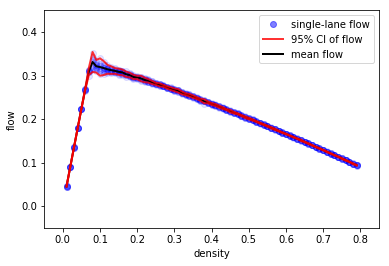

In [9]:
print "Figure 3. Traffic density vs. traffic flow.\n"
graph(lane_sizes=[1])

### Part 2: Multi-lane highways

Implement the 2-lane, symmetric, uni-directional, variable speed model in this paper: Rickert, M., et al. (1996). Two Lane Traffic Simulations using Cellular Automata. Physica A: Statistical Mechanics and its Applications, 231(4), 534–550.

We start looking at this model in class and you will have an opportunity there to share ideas and discuss problems you encounter. You will need complete this part of the assignment on your own though.

- A description, in your report, of how this model works. What are the assumptions, parameters, and update rules of the model? Do not just copy and paste from the paper. Explain the cellular automaton in your own words and as clearly as possible.
- Write well-structured and well-documented Python code to implement the model described in the paper.
- Visualize the state of this model over time, to show the typical traffic patterns that can emerge. Your results will again depend on traffic density.
- Analyze how much more traffic can flow through a multi-lane road, compare to a single lane road, at the same traffic density. Present your results in your report.

In [103]:
print "Figure 4. Two-lane model with traffic density set to 0.2.\n"
sim = TrafficSimulation(road_length = 50, traffic_density= 0.2, n_lanes = 2)
sim.simulate(iterations=5, burns = 10)

Figure 4. Two-lane model with traffic density set to 0.2.

.....3.......1....2...000................3.....1..
2....3.....1..2..2..1.100.1......2...........2....


........3......2.....3000...................3....2
...3....3....2..2..20.00.1..2......2............3.


..3........3......3..000.1......................4.
..4....4...3..1...200.0.1..2...3......3...........


2.....4........4...1.00.1.1.......................
.....3...2...2..2.000..1..2..2.....4.....3........


..2.......4......2.0.00..1.1......................
........3..2...20.000...1..1...2........5....4....




In [265]:
print "Figure 5. Two-lane model with traffic density set to 0.12.\n"
sim = TrafficSimulation(road_length = 50, traffic_density=0.12, n_lanes = 2)
sim.simulate(iterations=5, draw_separate_lanes=True, steps=10)

Figure 5. Two-lane model with traffic density set to 0.15.

The simulation cannot graph more steps than iterations.
Setting steps to: 5.
Lane number 1
...........4........1...2..1..0...2...............
...............4.....1....1.0.0.....2.............
...................1..1....01.0.......2...........
....................2..2...0.01.........2.........
......................2..2.0.0.1..........2.......


Lane number 2
......4............4....1..2...2............4.....
..........4............1.2...3...3..............5.
...4..........4.........2..3....3...3.............
.......5..........5.......3...4....2...3..........
............5..........5.....3....4..2....3.......




Figure 6. Single-lane vs. multi-lane.



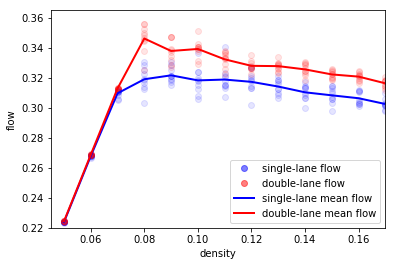

In [15]:
print "Figure 6. Single-lane vs. multi-lane.\n"
graph(lane_sizes=[1,2], densities=[.01*x for x in range(5,18)],xlim=[.045,0.17], ylim=[0.22,0.365])

Figure 7. Single-lane vs. double-lane vs. triple-lane.



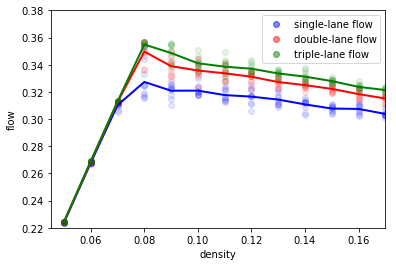

In [19]:
print "Figure 7. Single-lane vs. double-lane vs. triple-lane.\n"
graph(lane_sizes=[1,2,3], densities=[.01*x for x in range(5,18)], xlim=[.045,0.17], ylim=[0.22,0.38])

Figure 8. Traffic flow for n-lane road.


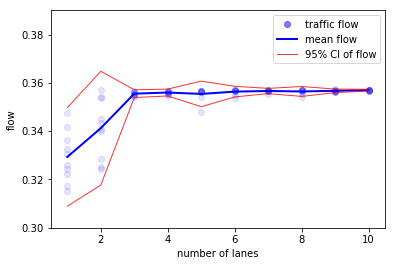

In [21]:
print "Figure 8. Traffic flow for n-lane road."

numRuns = 10
road_sizes = range(1, 11)
flow_rates = pd.DataFrame(index=range(numRuns),columns = road_sizes)
flow_metrics, flow_means = {}, {}

for size in road_sizes: # For each road
    temp_flow = []
    for run in range(numRuns): # For each simulation
        sim = TrafficSimulation(traffic_density=0.08, road_length = 1000, n_lanes=size)
        sim.simulate(draw=False, iterations=1000)
        temp_flow.append(np.mean(sim.traffic_flow))
        
    flow_rates[size] = temp_flow


flow_metrics = flow_rates.describe()
flow_means = flow_metrics.loc['mean'].values
flow_upper = flow_means + 1.96*flow_metrics.loc['std'].values
flow_lower = flow_means - 1.96*flow_metrics.loc['std'].values

plt.figure()
for size in road_sizes:
    plt.scatter([size for i in range(numRuns)], flow_rates[size],c='b',edgecolor='b',alpha=.1)
    
blue_toy, = plt.plot([],[], color='b', marker='o', label='traffic flow', alpha=.5, linestyle="")
means, = plt.plot(road_sizes,flow_means,c='b',lw=2, label="mean flow")
CI, = plt.plot(road_sizes,flow_upper, c='r', lw=1,alpha = .8, label="95% CI of flow")
plt.plot(road_sizes,flow_lower, c='r', lw=1, alpha = .8)
plt.legend(handles=[blue_toy, means, CI],facecolor="white") 
plt.xlabel("number of lanes")
plt.ylabel("flow")
plt.ylim(.30, .39)
plt.xlim(0.5, 10.5)
plt.show()

